## Lógica Computacional: 21/22## 
---
##Trabalho 2## 

$Grupo$ $7$ 

*   David José de Sousa Machado (A91665)
*   Ivo Miguel Gomes Lima (A90214)
---
#Inicialização

Para a resolução destes exercícios usamos a biblioteca [OR-Tools](https://developers.google.com/optimization) que criou uma interface para o SCIP. Esta biblioteca foi instalada com o commando `!pip install ortools`.

In [2]:
!pip install ortools

In [3]:
import networkx as nx
import random
import numpy as np
import math
from ortools.linear_solver import pywraplp

# Problema 2:
2. Considere-se um circuito booleano $\,\mathcal{C}\,$ com $\,n\,$ “wires” de “input” e um único “wire” de output.
    - O circuito é descrito num bi-grafo com uma classe de nodos representando “gates” e a segunda classe representando “wires” . 
    - Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo val contém uma variável SCIP; para as “gates” o campo val contém uma marca bo conjunto and, or, xor e not, que indica o tipo de “gate”. 
    - Com exceção de not, que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.
    - No grafo os arcos com origem numa determinada “gate” têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.
    - A semântica das várias “gates” é expressa em relações na Aritmética Linear Inteira, tal como está descrita em +Capítulo 2: Programação com Restrições (#LIA)

    1. Escreva um programa que, a partir do número, $n$ de “inputs” e de um parâmetro positivo $\gamma \ll 1$ como argumentos, gere aleatoriamente circuitos com “gates” or, and e not em que o número de and's é $\gamma \ast$ (número total de nodos).
    2. Escreva um programa Python que leia um circuito arbitrário descrito pelo bi-grafo anterior e formule as restrições (em Programação Inteira) que descrevem as várias “gates” do circuito.
    3. Usando os dois programas anteriores e o sistema SCIP, 
        1. Escreva um programa que determine um vetor de “inputs” $x \in \{0,1\}^n$ aceite pelo circuito (i.e. o respetivo output é $1$).
        2. Determine o vetor $x' \neq x$ , também aceite pelo circuito, que está mais próximo de $x$. 
        

**Gerar o circuito**

De forma a garantirmos que $and = \gamma \times $(número total de nodos) é uma condição válida, criamos uma função chamada `calc_and` que dado o valor de n e $\gamma$ acumula os resultados de $n \times \gamma \times 2 $ enquanto $n > 1$ o que resulta no numero de nós do grafo. 

> Nota: Esperamos que $\gamma$ seja menor que 0.5
#Implementação

In [4]:
def desenha(circ):
    labels = {n : circ.nodes[n]['node_type'] for n in circ}
    dic = {
        "INPUT": "#FFEF78",
        "WIRE": "#B1FFFD",
        "AND": "#9C19E0",
        "NOT": "#FF5DA2",
        "OR": "#1597BB"
    }
    colors = [dic[circ.nodes[n]['node_type']] for n in circ]
    nx.draw(circ, with_labels=True, labels=labels, node_size = 800, node_color=colors, font_weight='bold', pos = nx.spring_layout(circ)) 

def calc_and(n, gamma):
    n *= gamma * 2
    acc = n

    while n > 1:
        n *= gamma * 2
        acc += n
  
    return math.floor(acc) if math.floor(acc) % 2 == 0 else math.floor(acc) + 1

def gera_circuito(n, gamma):
    ors = random.randint(1, n) * 2
    nots = random.randint(1, n) * 2
    ands = calc_and(n+ors+nots, gamma)
    circuito = nx.DiGraph()
    gates = {
        "AND": (n, n+ands),
        "OR": (n+ands, n+ands+ors),
        "NOT": (n+ands+ors, n+ands+ors+nots)
    }

    # adding inputs
    for i in range(n):
        circuito.add_node(i, node_type="INPUT")
    # adding gates
    for n_type, (start, end) in gates.items():
        for i in range(start, end, 2):
            circuito.add_node(i, node_type=n_type)
            circuito.add_node(i+1, node_type="WIRE", val=None)
            # ligar gate ao wire
            circuito.add_edge(i, i+1)
    
    output = random.sample(list(range(gates["AND"][0]+1, gates["OR"][1], 2)), 1)[0]
    wires = {el for el in range(gates["AND"][0]+1, gates["NOT"][1], 2) if el != output}
    wires.union(set(range(0, gates["AND"][0])))

    vis = set()
    stack = [output]
    while stack and wires:
        el = stack.pop()

        if el in vis: continue
        vis.add(el)

        inputs = random.sample(wires, 1) if circuito.nodes[el]["node_type"] == "NOT" else random.sample(wires, random.randint(1, len(wires)))
        
        for input in inputs:
            circuito.add_edge(input, el-1)
            stack.append(input)
            wires.remove(input)
    

    disconnected = [el for el in range(gates["AND"][0], gates["NOT"][1], 2) if circuito.in_degree(el) == 0]
    for disc in disconnected:
        inp = random.randint(0, n-1) 
        circuito.add_edge(inp, disc)

    # ligar inputs a pelo menos uma gate
    for i in range(n):
        if circuito.out_degree(i) == 0:
            circuito.add_edge(i, output-1)
    
    gates["OUTPUT"] = output

    return gates, circuito

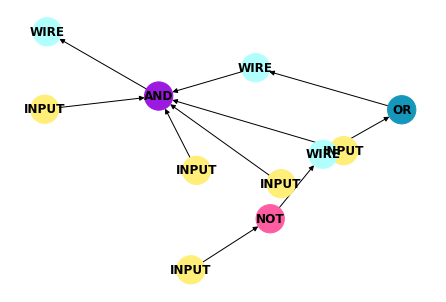

In [5]:
n, g = 5, 0.1
gates, circ = gera_circuito(n, g)
desenha(circ)

**Análise do Problema**

Tendo em conta o material fornecido pelo docente da disciplina [aqui](https://paper.dropbox.com/doc/Capitulo-2-Programacao-com-Restricoes-x8IebJsYYIvi0KYezj4Uu#:uid=140371385393078716549042&h2=Restri%C3%A7%C3%B5es-booleanas) podemos formalizar o seguinte conjunto de restrições:

1.   Tomando $X$ como a lista que contém todos os nodos ligados, para o caso da *gate* tipo $And$ devemos levar em conta o menor valor de *input*. Ou seja:

$$\forall_{n \in X} \ X_n \geq X_i \cdot \sum_{i \in X} X_n < X_i + len_{inputs}(X) $$

2.   Para um *gate* $Or$ temos de ter em atenção o maior valor de *input* pois o *output* depende dele. Isto é:
$$\forall_{n \in X} \ X_n \leq X_i \cdot \sum_{i \in X} X_n \geq X_i$$

3.   No tipo $Not$ a lista que contém todos os nodos ligados apenas possui 1 elemento, isto significa que se $X_n = 0 \rightarrow X_i = 1$ e vice-versa.
$$ X_n + Xi = 1 $$

In [6]:
def make_solver(G, gates):
    solver = pywraplp.Solver.CreateSolver("SCIP")
    wires = [n for n in G if G.nodes[n]["node_type"] == "WIRE"]
    X = {input: solver.BoolVar(str(input)) for input in G if G.nodes[input]["node_type"] == "INPUT" or G.nodes[input]["node_type"] == "WIRE"}


    for n in wires:
        inputs = [s for (s,t) in G.in_edges(n-1)]

        if G.nodes[n-1]["node_type"] == "AND":
            solver.Add(sum(X[i] for i in inputs) <= X[n]+len(inputs) - 1)
            for i in inputs:
                solver.Add(X[i] >= X[n])
        elif G.nodes[n-1]["node_type"] == "OR":
            solver.Add(X[n] <= sum(X[i] for i in inputs))
            for i in inputs:
                solver.Add(X[i] <= X[n])
        elif G.nodes[n-1]["node_type"] == "NOT":
            solver.Add(X[n] + X[inputs[0]] == 1)
    
    return solver, X

**Resolver o circuito**

In [7]:
def solve_circ(G, gates):
    solver, X = make_solver(G, gates)

    solver.Add(X[gates['OUTPUT']] == 1)

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        for n in X:
            G.nodes[n]['val'] = round(X[n].solution_value())
        
        res1 = [round(X[i].solution_value()) for i in range(gates["AND"][0])]
        if solver.NextSolution():
            res2 = [round(X[i].solution_value()) for i in range(gates["AND"][0])]
            return res1,res2
        else:
            return res1
    else:
        print("no solution found")

In [8]:
solve_circ(circ, gates)

[1, 0, 1, 1, 1]